# Guide for twinpy/plot/dos.py

In [1]:
%aiida
%reload_ext autoreload
%autoreload 2

In [27]:
# import os
# from pprint import pprint
# import numpy as np
# from matplotlib import pyplot as plt
# import twinpy
# from twinpy.interfaces.aiida.phonopy import AiidaPhonopyWorkChain
# from twinpy.interfaces.aiida.vasp import AiidaRelaxWorkChain
# from twinpy.interfaces.aiida.shear import AiidaShearWorkChain
# from twinpy.analysis.phonon_analyzer import PhononAnalyzer
# from twinpy.plot.dos import (TotalDosPlot,
#                              TotalDosesPlot)
# 
# jupyter_dir = os.path.join(os.path.dirname(twinpy.__file__), '..', 'jupyter')
# sys.path.append(os.path.join(jupyter_dir, 'site-packages'))
# from jupyter_help import show_info
# 
# shear_pk = 309999  # twinpy


import os
import sys
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
import twinpy
from twinpy.interfaces.aiida.base import get_cell_from_aiida
from twinpy.interfaces.aiida.vasp import (AiidaVaspWorkChain,
                                          AiidaRelaxWorkChain)
from twinpy.interfaces.aiida.phonopy import AiidaPhonopyWorkChain
from twinpy.interfaces.aiida.shear import AiidaShearWorkChain
from twinpy.interfaces.aiida.twinboundary import AiidaTwinBoudnaryRelaxWorkChain
from twinpy.analysis.twinboundary_analyzer import TwinBoundaryAnalyzer
from twinpy.file_io import write_thermal_ellipsoid
from twinpy.plot.dos import (TotalDosPlot,
                             PartialDosPlot,
                             TotalDosesPlot,
                             PartialDosesPlot,
                             )

jupyter_dir = os.path.join(os.path.dirname(twinpy.__file__), '..', 'jupyter')
sys.path.append(os.path.join(jupyter_dir, 'site-packages'))
from jupyter_help import show_info

hexagonal_relax_pk = 7887  # twinpy
hexagonal_phonon_pk = 289856  # twinpy
twinboundary_pk = 186343  # twinpy
additional_relax_pks = [267977, 279276, 282215, 283951]   # twinpy
twinboundary_phonon_pk = 286877  # twinpy
twinboundary_shear_relax_pks = [326425, 297874, 297890, 297907, 297924]
twinboundary_shear_phonon_pks = [326490, 299318, 300184, 300580, 300760]
shear_strain_ratios = [0.00, 0.02, 0.04, 0.06, 0.08]

In [3]:
aiida_twinboundary_relax = AiidaTwinBoudnaryRelaxWorkChain(load_node(twinboundary_pk))
twinboundary_analyzer = aiida_twinboundary_relax.get_twinboundary_analyzer(
                            twinboundary_phonon_pk=twinboundary_phonon_pk,
                            hexagonal_relax_pk=hexagonal_relax_pk,
                            hexagonal_phonon_pk=hexagonal_phonon_pk,
                            additional_relax_pks=additional_relax_pks)
original_cells = []
for ratio in shear_strain_ratios:
    original_cell = twinboundary_analyzer.get_shear_cell(
        shear_strain_ratio=ratio,
        is_standardize=False)
    original_cells.append(original_cell)
    
phonon_analyzers = []
for i in range(len(original_cells)):
    aiida_relax = AiidaRelaxWorkChain(load_node(twinboundary_shear_relax_pks[i]))
    relax_analyzer = aiida_relax.get_relax_analyzer(original_cell=original_cells[i])
    aiida_phonon = AiidaPhonopyWorkChain(load_node(twinboundary_shear_phonon_pks[i]))
    phonon_analyzer = aiida_phonon.get_phonon_analyzer(relax_analyzer=relax_analyzer)
    phonon_analyzers.append(phonon_analyzer)

twinboundary_shear_analyzer = \
    twinboundary_analyzer.get_twinboundary_shear_analyzer(
        shear_phonon_analyzers=phonon_analyzers,
        shear_strain_ratios=shear_strain_ratios)

phonon_analyzers = twinboundary_shear_analyzer.phonon_analyzers
phonon_analyzer = phonon_analyzers[0]
phonon_analyzer.run_mesh(interval=0.15, is_eigenvectors=True)

/home/mizo/src/github.com/kei0822kei/twinpy/twinpy/interfaces/aiida/base.py:105: UserWarning: process state: excepted
  warnings.warn("process state: %s" % self._process_state)
/home/mizo/src/github.com/kei0822kei/twinpy/twinpy/interfaces/aiida/vasp.py:309: UserWarning: Final structure could not find.
process state:excepted (pk=279276)
  self.process_state, self._node.pk))
/home/mizo/src/github.com/kei0822kei/twinpy/twinpy/interfaces/aiida/vasp.py:371: UserWarning: Could not find final static_pk calculation.
  warnings.warn("Could not find final static_pk calculation.")
/home/mizo/src/github.com/kei0822kei/twinpy/twinpy/interfaces/aiida/vasp.py:212: UserWarning: Final structure could not find.
process state:excepted (pk=281156)
  self.process_state, self._node.pk))


run mesh with [14  2  6]


# class TotalDosPlot

In [10]:
tdos = phonon_analyzer.get_total_dos()
tdp = TotalDosPlot(total_dos=tdos,
                   flip_xy=True)
show_info(tdp)

====== START method information ======

# ---------
# docstring
# ---------

    Total dos plot.
    

======= END method information =======




True


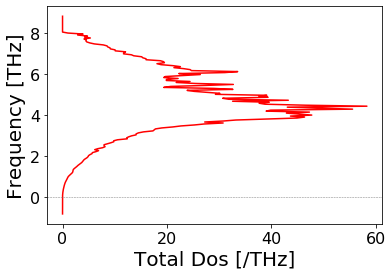

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
tdp.plot_total_dos(ax)
tdp.plot_vline(ax)
tdp.plot_xlabel(ax)
tdp.plot_ylabel(ax)

# class PartialDosPlot

In [23]:
pdos = phonon_analyzer.get_projected_dos()
pdp = PartialDosPlot(partial_dos=pdos, flip_xy=True)

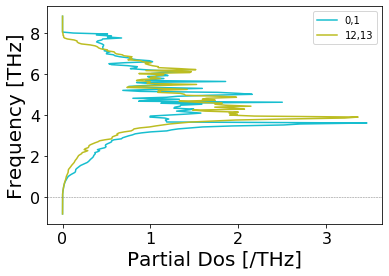

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
pdp.plot_partial_dos(ax=ax,
                     indices=[[0,1], [12,13]],
                     cs=None,
                     labels=['0,1', '12,13'])
pdp.plot_xlabel(ax)
pdp.plot_ylabel(ax)
pdp.plot_vline(ax)
pdp.plot_legend(ax)

# class TotalDosesPlot

In [139]:
twinboundary_shear_analyzer.run_mesh(interval=0.05)
total_doses = twinboundary_shear_analyzer.get_total_doses(freq_max=1, freq_pitch=0.005, sigma=0.03)
tdsp = TotalDosesPlot(total_doses=total_doses)
show_info(tdsp, is_class=True)

run mesh with [40  4 18]
run mesh with [18 40  4]
run mesh with [18 40  4]
run mesh with [18 40  4]
run mesh with [18 40  4]
====== START class information ======

# ---------
# docstring
# ---------

    Total Doses Plot.
    

# ----
# init
# ----

        Args:
            total_doses (list): List of TotalDos class object.
            flip_xy (bool): Whether to flip x and y.
                            This cannot change later.
        

# ---------------
# attribute names
# ---------------
['_total_doses',
 '_flip_xy',
 '_dosplots',
 '_cs',
 '_alphas',
 '_linewidths',
 '_linestyles']

# ------
# values
# ------
{'_alphas': [1.0, 0.6, 0.6, 0.6, 1.0],
 '_cs': ['r', 'r', 'r', 'r', 'r'],
 '_dosplots': [<twinpy.plot.dos.TotalDosPlot object at 0x7fa0854933d0>,
 '_flip_xy': False,
 '_linestyles': ['dashed', 'dotted', 'dotted', 'dotted', 'solid'],
 '_linewidths': [1.5, 1.0, 1.0, 1.0, 1.5],
 '_total_doses': [<phonopy.phonon.dos.TotalDos object at 0x7fa08549f990>,
                  <phonopy.

(0, 4)

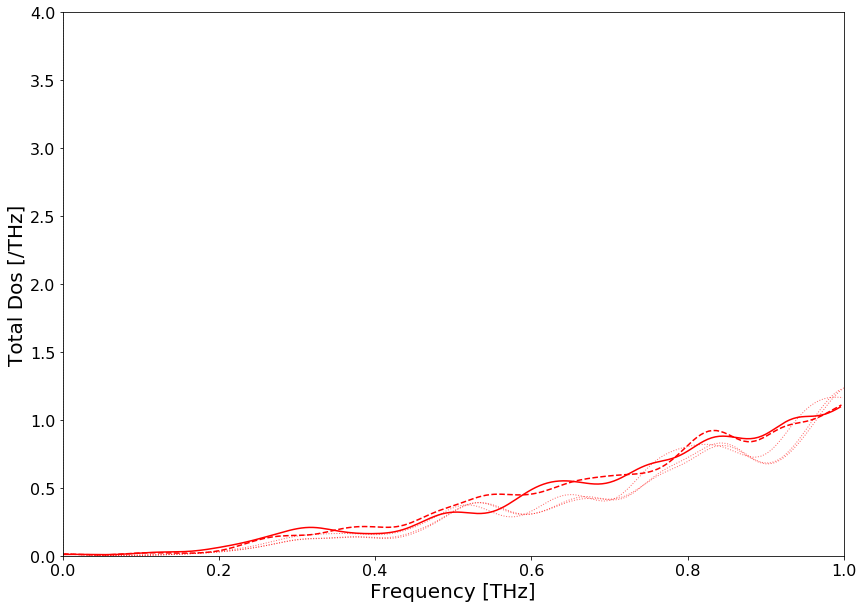

In [140]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)
tdsp.plot_total_doses(ax)
tdsp.set_xlim(ax=ax, xmin=0., xmax=1)
ax.set_ylim(0, 4)

(0, 4)

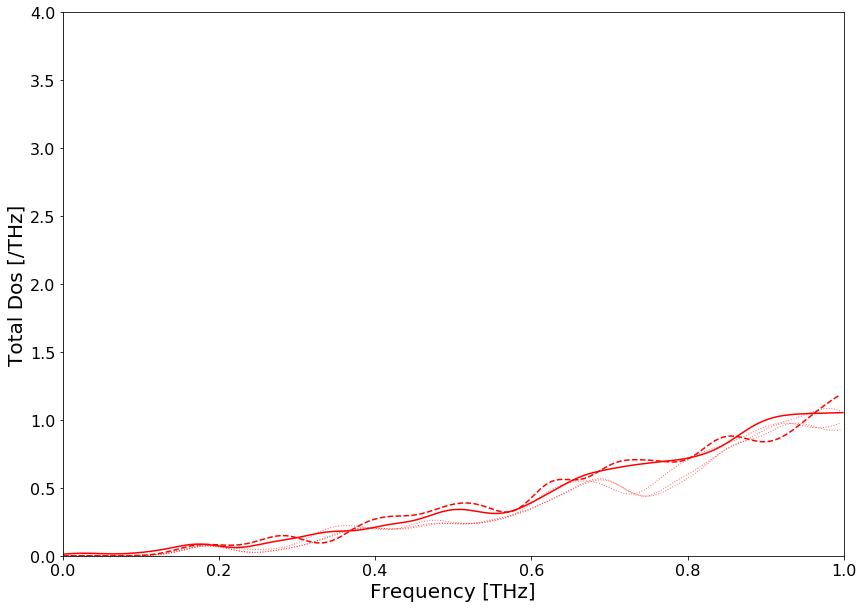

In [135]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)
tdsp.plot_total_doses(ax)
tdsp.set_xlim(ax=ax, xmin=0., xmax=1)
ax.set_ylim(0, 4)

# class PartialDoses

In [63]:
# twinboundary_shear_analyzer.run_mesh(interval=0.05, is_eigenvectors=True)
projected_doses = twinboundary_shear_analyzer.get_projected_doses(freq_max=1, freq_pitch=0.005, sigma=0.01)
pdsp = PartialDosesPlot(partial_doses=projected_doses)
show_info(pdsp, is_class=True)

====== START class information ======

# ---------
# docstring
# ---------

    Partial Doses Plot.
    

# ----
# init
# ----

        Args:
            partial_doses (list): List of PartialDos class object.
            flip_xy (bool): Whether to flip x and y.
                            This cannot change later.
        

# ---------------
# attribute names
# ---------------
['_partial_doses', '_flip_xy', '_pdosplots']

# ------
# values
# ------
{'_flip_xy': False,
 '_partial_doses': [<phonopy.phonon.dos.PartialDos object at 0x7f396aa9c390>,
 '_pdosplots': [<twinpy.plot.dos.PartialDosPlot object at 0x7f39653e1fd0>,
                <twinpy.plot.dos.PartialDosPlot object at 0x7f39653e1750>]}

======= END class information =======




0 0
['#17becf']
[[0]]
0 1
['#17becf']
[[0]]
0 2
['#17becf']
[[0]]
0 3
['#17becf']
[[0]]
0 4
['#17becf']
[[0]]


(0, 3)

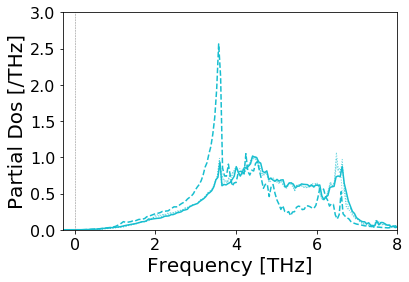

In [89]:
fig = plt.figure()
ax = fig.add_subplot(111)
# pdsp.plot_partial_doses(ax, indices=[[0,1],[12,13]])
pdsp.plot_partial_doses(ax, indices=[[0]])
pdsp.set_xlim(ax, 0, 1)
ax.set_xlim(-0.3, 8)
ax.set_ylim(0, 3)
# ax.legend()